<a href="https://colab.research.google.com/github/kulakovand/colabr_epo/blob/main/work_retinanet_object_Detection_7_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object Detection with RetinaNet

**Author:** [Srihari Humbarwadi](https://twitter.com/srihari_rh)<br>
**Date created:** 2020/05/17<br>
**Last modified:** 2020/07/14<br>
**Description:** Implementing RetinaNet: Focal Loss for Dense Object Detection.

## Introduction

Обнаружение объектов очень важная проблема в компьютере
зрение. Здесь перед моделью стоит задача локализации объектов, присутствующих в
изображение, и в то же время классифицируя их по разным категориям.
Модели обнаружения объектов можно разделить на «одноэтапные» и «одноэтапные».
«двухступенчатые» детекторы. Двухступенчатые детекторы часто более точны, но
стоимость того, чтобы быть медленнее. Здесь, в этом примере, мы реализуем RetinaNet,
популярный одноступенчатый детектор, который является точным и быстрым.
RetinaNet использует пирамидальную сеть функций для эффективного обнаружения объектов в
несколько масштабов и вводит новую функцию потерь, функцию очаговых потерь, чтобы облегчить
проблема крайнего дисбаланса классов переднего плана и фона.

**References:**

- [RetinaNet Paper](https://arxiv.org/abs/1708.02002)
- [Feature Pyramid Network Paper](https://arxiv.org/abs/1612.03144)

In [1]:
import tensorflow as tf
print(tf.__version__)


2.12.0


In [2]:
!pip install tensorflow==2.11.0 #поставить версию ниже


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 76.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 66.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 119.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 kB 49.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 121.5 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator-2.12.0
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.0
    Uninstalling tensorboard-data-server-0.7.0:
      Successfully uninstalled tensorboard-data-ser

In [3]:
tf.version.VERSION

'2.12.0'

In [4]:
# импорт библиотек
import os
import re
import zipfile

import numpy as np
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow_datasets as tfds


##Загрузка набора данных COCO2017

Обучение всему набору данных COCO2017, содержащему около 118 тыс. изображений, занимает много времени, поэтому в этом примере для обучения мы будем использовать меньший подмножество из примерно 500 изображений.





In [5]:
url = "https://github.com/srihari-humbarwadi/datasets/releases/download/v0.1.0/data.zip"#откуда скачивать датасет
filename = os.path.join(os.getcwd(), "data.zip")#погдготовка переменной с именем архива датасета, который будем скачивать
keras.utils.get_file(filename, url)#скачивание архива датасета


with zipfile.ZipFile("data.zip", "r") as z_fp:#распаковка скаченного архива
    z_fp.extractall("./")


560525318/560525318 [==============================] - 22s 0us/step


In [6]:
#print (filename)

In [7]:
#print (os.getcwd())

##Реализация служебных функций
Ограничивающие рамки могут быть представлены несколькими способами, наиболее распространенными являются следующие форматы:

Сохранение координат углов [xmin, ymin, xmax, ymax]
Хранение координат центра и размеров коробки [x, y, ширина, высота]
Поскольку нам нужны оба формата, мы будем реализовывать функции для преобразования между форматами.

In [8]:

def swap_xy(boxes):
    """Обмен порядком координат x и y ящиков.

    Аргументы:
       коробки: тензор с формой `(num_boxes, 4)`, представляющий ограничивающие рамки.

     Возвращает:
       поменялись местами коробки с формой такой же, как у коробок.
     """

    return tf.stack([boxes[:, 1], boxes[:, 0], boxes[:, 3], boxes[:, 2]], axis=-1)


def convert_to_xywh(boxes):
    """Изменяет формат поля на центр, ширину и высоту.

     Аргументы:
       коробки: тензор ранга 2 или выше в форме `(..., num_boxes, 4)`
         представление ограничивающих рамок, где каждая рамка имеет формат
         `[xmin, ymin, xmax, ymax]`.

     Возвращает:
       преобразованные коробки с формой, такой же, как у коробок.
     """
    return tf.concat(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]],
        axis=-1,
    )


def convert_to_corners(boxes):

    """Изменяет формат поля на угловые координаты

     Аргументы:
       коробки: тензор ранга 2 или выше в форме `(..., num_boxes, 4)`
         представление ограничивающих рамок, где каждая рамка имеет формат
         `[х, у, ширина, высота]`.

     Возвращает:
       преобразованные коробки с формой, такой же, как у коробок.
     """
    return tf.concat(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0],
        axis=-1,
    )


In [9]:
bbox = tf.stack(
        [
          #  [10.0],
          #  [0.0],
          #  [0.0],
          #  [10.0],
          [0.0,10.0],
           [10.0,10.0],
           [10.0,0.0],
           [0.0,0.0],
        ],
        axis=-1,
    )
print(convert_to_xywh(bbox))

tf.Tensor(
[[  5.   5.  10. -10.]
 [  5.   5. -10. -10.]], shape=(2, 4), dtype=float32)


In [10]:
#print(convert_to_corners(bbox))

tf.Tensor(
[[-5. 10.  5. 10.]
 [10. 10. 10. 10.]], shape=(2, 4), dtype=float32)


In [11]:
#print(swap_xy(bbox))

tf.Tensor(
[[10.  0.  0. 10.]
 [10. 10.  0.  0.]], shape=(2, 4), dtype=float32)


## Вычисление попарного пересечения над объединением (IOU)

Как мы увидим позже в примере, мы будем назначать наземные поля истины.
для привязки блоков в зависимости от степени перекрытия. Это потребует от нас
рассчитать Intersection Over Union (IOU) между всеми якорями
коробки и пары наземных коробок истины.

In [12]:

def compute_iou(boxes1, boxes2):
    """Вычисляет попарную матрицу IOU для заданных двух наборов коробок

     Аргументы:
       box1: тензор формы `(N, 4)`, представляющий ограничивающие рамки.
         где каждое поле имеет формат `[x, y, ширина, высота]`.
         box2: тензор формы `(M, 4)`, представляющий ограничивающие рамки.
         где каждое поле имеет формат `[x, y, ширина, высота]`.

     Возвращает:
       попарная матрица IOU формы `(N, M)`, где значение в i-й строке
         j-й столбец содержит долговую расписку между i-м ящиком и j-м ящиком из
         ящики1 и ящики2 соответственно.
     """
    boxes1_corners = convert_to_corners(boxes1)
    boxes2_corners = convert_to_corners(boxes2)
    lu = tf.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2])
    rd = tf.minimum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])
    intersection = tf.maximum(0.0, rd - lu)
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    boxes1_area = boxes1[:, 2] * boxes1[:, 3]
    boxes2_area = boxes2[:, 2] * boxes2[:, 3]
    union_area = tf.maximum(
        boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8
    )
    return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)


def visualize_detections(
    image, boxes, classes, scores, figsize=(7, 7), linewidth=1, color=[0, 0, 1]
):
    """Visualize Detections"""
    image = np.array(image, dtype=np.uint8)
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    for box, _cls, score in zip(boxes, classes, scores):
        text = "{}: {:.2f}".format(_cls, score)
        x1, y1, x2, y2 = box
        w, h = x2 - x1, y2 - y1
        patch = plt.Rectangle(
            [x1, y1], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        ax.text(
            x1,
            y1,
            text,
            bbox={"facecolor": color, "alpha": 0.4},
            clip_box=ax.clipbox,
            clip_on=True,
        )
    plt.show()
    return ax


## Реализация генератора якоря
Блоки привязки — это блоки фиксированного размера, которые модель использует для прогнозирования ограничивающего блока объекта. Он делает это путем регрессии смещения между положением центра объекта и центром поля привязки, а затем использует ширину и высоту поля привязки для прогнозирования относительного масштаба объекта. В случае RetinaNet каждое местоположение на заданной карте объектов имеет девять якорных полей (в трех масштабах и трех соотношениях).

In [13]:

class AnchorBox:
    """Создает блоки привязки.

     Этот класс имеет операции для создания блоков привязки для карт объектов в
     шаги `[8, 16, 32, 64, 128]`. Где каждый якорь, каждая коробка
     формат `[x, y, ширина, высота]`.

     Атрибуты:
       aspect_ratios: список значений с плавающей запятой, представляющих соотношение сторон
         якорные поля в каждом месте на карте объектов
       Scales: список значений с плавающей запятой, представляющих масштаб полей привязки.
         в каждом месте на карте объектов.
       num_anchors: количество якорей в каждом месте на карте объектов.
       области: список значений с плавающей запятой, представляющих области якоря.
         поля для каждой карты объектов в пирамиде объектов.
       шаги: список значений с плавающей запятой, представляющих шаги для каждой функции.
         карту в пирамиде признаков.
     """

    def __init__(self):
        self.aspect_ratios = [0.5, 1.0, 2.0]
        self.scales = [2 ** x for x in [0, 1 / 3, 2 / 3]]

        self._num_anchors = len(self.aspect_ratios) * len(self.scales)
        self._strides = [2 ** i for i in range(3, 8)]
        self._areas = [x ** 2 for x in [32.0, 64.0, 128.0, 256.0, 512.0]]
        self._anchor_dims = self._compute_dims()

    def _compute_dims(self):
        """Вычисляет размеры блока привязки для всех соотношений и масштабов на всех уровнях
         пирамиды признаков.
        """
        anchor_dims_all = []
        for area in self._areas:
            anchor_dims = []
            for ratio in self.aspect_ratios:
                anchor_height = tf.math.sqrt(area / ratio)
                anchor_width = area / anchor_height
                dims = tf.reshape(
                    tf.stack([anchor_width, anchor_height], axis=-1), [1, 1, 2]
                )
                for scale in self.scales:
                    anchor_dims.append(scale * dims)
            anchor_dims_all.append(tf.stack(anchor_dims, axis=-2))
        return anchor_dims_all

    def _get_anchors(self, feature_height, feature_width, level):
        """Создает поля привязки для заданного размера и уровня карты объектов

         Аргументы:
           feature_height: целое число, представляющее высоту карты объектов.
           feature_width: целое число, представляющее ширину карты объектов.
           level: целое число, представляющее уровень карты объектов в
             особенность пирамиды.

         Возвращает:
           анкерные коробки с формой
           `(feature_height * feature_width * num_anchors, 4)`
        """
        rx = tf.range(feature_width, dtype=tf.float32) + 0.5
        ry = tf.range(feature_height, dtype=tf.float32) + 0.5
        centers = tf.stack(tf.meshgrid(rx, ry), axis=-1) * self._strides[level - 3]
        centers = tf.expand_dims(centers, axis=-2)
        centers = tf.tile(centers, [1, 1, self._num_anchors, 1])
        dims = tf.tile(
            self._anchor_dims[level - 3], [feature_height, feature_width, 1, 1]
        )
        anchors = tf.concat([centers, dims], axis=-1)
        return tf.reshape(
            anchors, [feature_height * feature_width * self._num_anchors, 4]
        )

    def get_anchors(self, image_height, image_width):
        """Создает поля привязки для всех карт объектов пирамиды объектов.

         Аргументы:
           image_height: высота входного изображения.
           image_width: ширина входного изображения.

         Возвращает:
           якорные блоки для всех карт объектов, сложенные в виде единого тензора
             с формой `(total_anchors, 4)`
        """
        anchors = [
            self._get_anchors(
                tf.math.ceil(image_height / 2 ** i),
                tf.math.ceil(image_width / 2 ** i),
                i,
            )
            for i in range(3, 8)
        ]
        return tf.concat(anchors, axis=0)

        



## Предварительная обработка данных
Предварительная обработка изображений включает два этапа:

Изменение размера изображения: изображения изменяются таким образом, чтобы самый короткий размер был равен 800 пикселям, после изменения размера, если самая длинная сторона изображения превышает 1333 пикселя, размер изображения изменяется таким образом, что самый длинный размер теперь ограничен 1333 пикселями.
Применение аугментации: к изображениям применяются только случайные колебания масштаба и случайное горизонтальное отражение.
Наряду с изображениями ограничивающие рамки масштабируются и при необходимости переворачиваются.

In [14]:

def random_flip_horizontal(image, boxes):
    """Переворачивает изображение и прямоугольники по горизонтали с вероятностью 50%

     Аргументы:
       изображение: Трехмерный тензор формы `(высота, ширина, каналы)`, представляющий
         изображение.
       коробки: тензор с формой `(num_boxes, 4)`, представляющий ограничивающие рамки,
         имеющие нормированные координаты.

     Возвращает:
       Случайно перевернутое изображение и коробки
     """
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        boxes = tf.stack(
            [1 - boxes[:, 2], boxes[:, 1], 1 - boxes[:, 0], boxes[:, 3]], axis=-1
        )
    return image, boxes


def resize_and_pad_image(
    image, min_side=800.0, max_side=1333.0, jitter=[640, 1024], stride=128.0
):
    """Изменяет размер и дополняет изображение с сохранением соотношения сторон.

     1. Изменяет размеры изображений так, чтобы более короткая сторона была равна `min_side`
     2. Если длинная сторона больше max_side, измените размер изображения.
       с более длинной стороной, равной `max_side`
     3. Дополните нулями справа и снизу, чтобы форма изображения делилась на
     `шаг`

     Аргументы:
       изображение: Трехмерный тензор формы `(высота, ширина, каналы)`, представляющий
         изображение.
       min_side: размер более короткой стороны изображения изменяется до этого значения, если
         «дрожание» установлено на «Нет».
       max_side: если более длинная сторона изображения превышает это значение после
         изменение размера, размер изображения изменяется таким образом, что длинная сторона теперь равна
         это значение.
       дрожание: список с плавающей запятой, содержащий минимальный и максимальный размер для масштаба
         дрожь. Если доступно, более короткая сторона изображения будет
         изменяется на случайное значение в этом диапазоне.
       шаг: шаг наименьшей карты объектов в пирамиде объектов.
         Можно рассчитать с помощью `image_size/feature_map_size`.

     Возвращает:
       изображение: изображение изменено и дополнено.
       image_shape: Форма изображения до заполнения.
       ratio: Коэффициент масштабирования, используемый для изменения размера изображения.
    """
    
    image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)
    if jitter is not None:
        min_side = tf.random.uniform((), jitter[0], jitter[1], dtype=tf.float32)
    ratio = min_side / tf.reduce_min(image_shape)
    if ratio * tf.reduce_max(image_shape) > max_side:
        ratio = max_side / tf.reduce_max(image_shape)
    image_shape = ratio * image_shape
    image = tf.image.resize(image, tf.cast(image_shape, dtype=tf.int32))
    padded_image_shape = tf.cast(
        tf.math.ceil(image_shape / stride) * stride, dtype=tf.int32
    )
    image = tf.image.pad_to_bounding_box(
        image, 0, 0, padded_image_shape[0], padded_image_shape[1]
    )
    return image, image_shape, ratio


def preprocess_data(sample):
    """Применяет этап предварительной обработки к одному образцу

     Аргументы:
       образец: словарь, представляющий одну обучающую выборку.

     Возвращает:
       изображение: измененный размер и дополненное изображение с примененным случайным горизонтальным отражением.
       bbox: ограничивающие рамки формы `(num_objects, 4)`, где каждая рамка
         формата `[x, y, ширина, высота]`.
       class_id: тензор, представляющий идентификатор класса объектов, имеющий
         форма `(num_objects,)`.
    """
    image = sample["image"]
    bbox = swap_xy(sample["objects"]["bbox"])
    class_id = tf.cast(sample["objects"]["label"], dtype=tf.int32)

    image, bbox = random_flip_horizontal(image, bbox)
    image, image_shape, _ = resize_and_pad_image(image)

    bbox = tf.stack(
        [
            bbox[:, 0] * image_shape[1],
            bbox[:, 1] * image_shape[0],
            bbox[:, 2] * image_shape[1],
            bbox[:, 3] * image_shape[0],
        ],
        axis=-1,
    )
    bbox = convert_to_xywh(bbox)
    return image, bbox, class_id


## Метки кодирования
Необработанные метки, состоящие из ограничивающих рамок и идентификаторов классов, необходимо преобразовать в цели для обучения. Это преобразование состоит из следующих шагов:

Создание блоков привязки для заданных размеров изображения
Назначение блоков наземной истины блокам привязки
Поля привязки, которым не назначены какие-либо объекты, либо назначаются фоновому классу, либо игнорируются в зависимости от долговой расписки.
Генерация целей классификации и регрессии с использованием полей привязки

In [15]:

class LabelEncoder:
    """Преобразует необработанные метки в цели для обучения.

     Этот класс имеет операции для создания целей для партии образцов, которые
     состоит из входных изображений, ограничивающих рамок для присутствующих объектов и
     их идентификаторы классов.

     Атрибуты:
       anchor_box: Генератор якорных рамок для кодирования ограничивающих рамок.
       box_variance: коэффициенты масштабирования, используемые для масштабирования целей ограничительной рамки.
    """

    def __init__(self):
        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32
        )

    def _match_anchor_boxes(
        self, anchor_boxes, gt_boxes, match_iou=0.5, ignore_iou=0.4
    ):
        """Сопоставляет блоки наземной истины с блоками привязки на основе долговой расписки.

         1. Вычисляет парные IOU для M `anchor_boxes` и N `gt_boxes`
           чтобы получить матрицу в форме `(M, N)`.
         2. Наземный блок правды с максимальным IOU в каждой строке назначается
           поле привязки при условии, что долговая расписка больше, чем `match_iou`.
         3. Если максимальное IOU в строке меньше, чем `ignore_iou`, якорь
           box назначается фоновым классом.
         4. Остальные поля привязки, которым не назначен какой-либо класс,
           игнорируются во время обучения.

         Аргументы:
           anchor_boxes: тензор с плавающей запятой формы `(total_anchors, 4)`
             представляющие все поля привязки для заданной формы входного изображения,
             где каждое поле привязки имеет формат `[x, y, ширина, высота]`.
           gt_boxes: тензор с плавающей запятой формы `(num_objects, 4)`, представляющий
             наземные блоки правды, где каждый блок имеет формат
             `[х, у, ширина, высота]`.
           match_iou: значение с плавающей запятой, представляющее минимальный порог IOU для
             определение того, может ли блок истинности основания быть назначен блоку привязки.
           ignore_iou: значение с плавающей запятой, представляющее порог IOU, ниже которого
             поле привязки назначается фоновому классу.

         Возвращает:
           matched_gt_idx: индекс совпавшего объекта
           Positive_mask: маска для якорных блоков, которым назначена земля.
             ящики правды.
           ignore_mask: маска для полей привязки, которые необходимо игнорировать во время
             обучение
        """
        iou_matrix = compute_iou(anchor_boxes, gt_boxes)
        max_iou = tf.reduce_max(iou_matrix, axis=1)
        matched_gt_idx = tf.argmax(iou_matrix, axis=1)
        positive_mask = tf.greater_equal(max_iou, match_iou)
        negative_mask = tf.less(max_iou, ignore_iou)
        ignore_mask = tf.logical_not(tf.logical_or(positive_mask, negative_mask))
        return (
            matched_gt_idx,
            tf.cast(positive_mask, dtype=tf.float32),
            tf.cast(ignore_mask, dtype=tf.float32),
        )

    def _compute_box_target(self, anchor_boxes, matched_gt_boxes):
        """Превращает наземные ящики правды в цели для обучения"""
        box_target = tf.concat(
            [
                (matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:],
                tf.math.log(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:]),
            ],
            axis=-1,
        )
        box_target = box_target / self._box_variance
        return box_target

    def _encode_sample(self, image_shape, gt_boxes, cls_ids):
        """Создает коробки и цели классификации для одного образца"""
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        cls_ids = tf.cast(cls_ids, dtype=tf.float32)
        matched_gt_idx, positive_mask, ignore_mask = self._match_anchor_boxes(
            anchor_boxes, gt_boxes
        )
        matched_gt_boxes = tf.gather(gt_boxes, matched_gt_idx)
        box_target = self._compute_box_target(anchor_boxes, matched_gt_boxes)
        matched_gt_cls_ids = tf.gather(cls_ids, matched_gt_idx)
        cls_target = tf.where(
            tf.not_equal(positive_mask, 1.0), -1.0, matched_gt_cls_ids
        )
        cls_target = tf.where(tf.equal(ignore_mask, 1.0), -2.0, cls_target)
        cls_target = tf.expand_dims(cls_target, axis=-1)
        label = tf.concat([box_target, cls_target], axis=-1)
        return label

    def encode_batch(self, batch_images, gt_boxes, cls_ids):
        """Создает коробки и цели классификации для партии"""
        images_shape = tf.shape(batch_images)
        batch_size = images_shape[0]

        labels = tf.TensorArray(dtype=tf.float32, size=batch_size, dynamic_size=True)
        for i in range(batch_size):
            label = self._encode_sample(images_shape, gt_boxes[i], cls_ids[i])
            labels = labels.write(i, label)
        batch_images = tf.keras.applications.resnet.preprocess_input(batch_images)
        return batch_images, labels.stack()


## Построение магистрали ResNet50
RetinaNet использует магистраль на основе ResNet, с помощью которой строится сеть пирамиды функций. В примере мы используем ResNet50 в качестве основы и возвращаем карты функций на шагах 8, 16 и 32.

In [16]:

def get_backbone():
    """Создает ResNet50 с предварительно обученными весами imagenet"""
    backbone = keras.applications.ResNet50(
        include_top=False, input_shape=[None, None, 3]
    )
    c3_output, c4_output, c5_output = [
        backbone.get_layer(layer_name).output
        for layer_name in ["conv3_block4_out", "conv4_block6_out", "conv5_block3_out"]
    ]
    return keras.Model(
        inputs=[backbone.inputs], outputs=[c3_output, c4_output, c5_output]
    )


## Построение пирамидальной сети объектов в качестве пользовательского слоя

In [17]:

class FeaturePyramid(keras.layers.Layer):
    """Строит пирамиду функций с картами функций из основы.

     Атрибуты:
       num_classes: количество классов в наборе данных.
       основа: основа для построения пирамиды функций.
         В настоящее время поддерживает только ResNet50.
    """

    def __init__(self, backbone=None, **kwargs):
        super().__init__(name="FeaturePyramid", **kwargs)
        self.backbone = backbone if backbone else get_backbone()
        self.conv_c3_1x1 = keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c4_1x1 = keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c5_1x1 = keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c3_3x3 = keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c4_3x3 = keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c5_3x3 = keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c6_3x3 = keras.layers.Conv2D(256, 3, 2, "same")
        self.conv_c7_3x3 = keras.layers.Conv2D(256, 3, 2, "same")
        self.upsample_2x = keras.layers.UpSampling2D(2)

    def call(self, images, training=False):
        c3_output, c4_output, c5_output = self.backbone(images, training=training)
        p3_output = self.conv_c3_1x1(c3_output)
        p4_output = self.conv_c4_1x1(c4_output)
        p5_output = self.conv_c5_1x1(c5_output)
        p4_output = p4_output + self.upsample_2x(p5_output)
        p3_output = p3_output + self.upsample_2x(p4_output)
        p3_output = self.conv_c3_3x3(p3_output)
        p4_output = self.conv_c4_3x3(p4_output)
        p5_output = self.conv_c5_3x3(p5_output)
        p6_output = self.conv_c6_3x3(c5_output)
        p7_output = self.conv_c7_3x3(tf.nn.relu(p6_output))
        return p3_output, p4_output, p5_output, p6_output, p7_output


## Построение заголовков классификации и блочной регрессии.
Модель RetinaNet имеет отдельные главы для регрессии ограничивающей рамки и для прогнозирования вероятностей классов для объектов. Эти головы являются общими для всех карт признаков пирамиды признаков.

In [18]:

def build_head(output_filters, bias_init):
    """Создает заголовок прогнозов класса/блока.

     Аргументы:
       output_filters: количество сверточных фильтров в последнем слое.
       bias_init: Инициализатор смещения для окончательного слоя свертки.

     Возвращает:
       Последовательная модель keras, представляющая классификацию
         или заголовок регрессии блока в зависимости от `output_filters`.
    """
    head = keras.Sequential([keras.Input(shape=[None, None, 256])])
    kernel_init = tf.initializers.RandomNormal(0.0, 0.01)
    for _ in range(4):
        head.add(
            keras.layers.Conv2D(256, 3, padding="same", kernel_initializer=kernel_init)
        )
        head.add(keras.layers.ReLU())
    head.add(
        keras.layers.Conv2D(
            output_filters,
            3,
            1,
            padding="same",
            kernel_initializer=kernel_init,
            bias_initializer=bias_init,
        )
    )
    return head


## Создание RetinaNet с использованием модели подклассов

In [19]:

class RetinaNet(keras.Model):
    """Подкласс модели Keras, реализующий архитектуру RetinaNet.

     Атрибуты:
       num_classes: количество классов в наборе данных.
       основа: основа для построения пирамиды функций.
         В настоящее время поддерживает только ResNet50.
    """

    def __init__(self, num_classes, backbone=None, **kwargs):
        super().__init__(name="RetinaNet", **kwargs)
        self.fpn = FeaturePyramid(backbone)
        self.num_classes = num_classes

        prior_probability = tf.constant_initializer(-np.log((1 - 0.01) / 0.01))
        self.cls_head = build_head(9 * num_classes, prior_probability)
        self.box_head = build_head(9 * 4, "zeros")

    def call(self, image, training=False):
        features = self.fpn(image, training=training)
        N = tf.shape(image)[0]
        cls_outputs = []
        box_outputs = []
        for feature in features:
            box_outputs.append(tf.reshape(self.box_head(feature), [N, -1, 4]))
            cls_outputs.append(
                tf.reshape(self.cls_head(feature), [N, -1, self.num_classes])
            )
        cls_outputs = tf.concat(cls_outputs, axis=1)
        box_outputs = tf.concat(box_outputs, axis=1)
        return tf.concat([box_outputs, cls_outputs], axis=-1)


## Реализация пользовательского слоя для декодирования прогнозов

In [20]:

class DecodePredictions(tf.keras.layers.Layer):
    """Слой Keras, который декодирует прогнозы модели RetinaNet.

     Атрибуты:
       num_classes: количество классов в наборе данных
       trust_threshold: минимальная вероятность класса, ниже которой обнаружения
         обрезаются.
       nms_iou_threshold: порог IOU для операции NMS
       max_detections_per_class: максимальное количество обнаружений, которые необходимо сохранить на
        сорт.
       max_detections: максимальное количество обнаружений для всех
         классы.
       box_variance: Коэффициенты масштабирования, используемые для масштабирования ограничивающей рамки.
         предсказания.
    """

    def __init__(
        self,
        num_classes=80,
        confidence_threshold=0.05,
        nms_iou_threshold=0.5,
        max_detections_per_class=100,
        max_detections=100,
        box_variance=[0.1, 0.1, 0.2, 0.2],
        **kwargs
    ):
        super().__init__(**kwargs)
        self.num_classes = num_classes
        self.confidence_threshold = confidence_threshold
        self.nms_iou_threshold = nms_iou_threshold
        self.max_detections_per_class = max_detections_per_class
        self.max_detections = max_detections

        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32
        )

    def _decode_box_predictions(self, anchor_boxes, box_predictions):
        boxes = box_predictions * self._box_variance
        boxes = tf.concat(
            [
                boxes[:, :, :2] * anchor_boxes[:, :, 2:] + anchor_boxes[:, :, :2],
                tf.math.exp(boxes[:, :, 2:]) * anchor_boxes[:, :, 2:],
            ],
            axis=-1,
        )
        boxes_transformed = convert_to_corners(boxes)
        return boxes_transformed

    def call(self, images, predictions):
        image_shape = tf.cast(tf.shape(images), dtype=tf.float32)
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        box_predictions = predictions[:, :, :4]
        cls_predictions = tf.nn.sigmoid(predictions[:, :, 4:])
        boxes = self._decode_box_predictions(anchor_boxes[None, ...], box_predictions)

        return tf.image.combined_non_max_suppression(
            tf.expand_dims(boxes, axis=2),
            cls_predictions,
            self.max_detections_per_class,
            self.max_detections,
            self.nms_iou_threshold,
            self.confidence_threshold,
            clip_boxes=False,
        )


## Реализация Smooth L1 loss и Focal Loss в качестве пользовательских потерь keras

In [21]:

class RetinaNetBoxLoss(tf.losses.Loss):
    """Реализует гладкую потерю L1"""

    def __init__(self, delta):
        super().__init__(
            reduction="none", name="RetinaNetBoxLoss"
        )
        self._delta = delta

    def call(self, y_true, y_pred):
        difference = y_true - y_pred
        absolute_difference = tf.abs(difference)
        squared_difference = difference ** 2
        loss = tf.where(
            tf.less(absolute_difference, self._delta),
            0.5 * squared_difference,
            absolute_difference - 0.5,
        )
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetClassificationLoss(tf.losses.Loss):
    """Реализует очаговую потерю"""

    def __init__(self, alpha, gamma):
        super().__init__(
            reduction="none", name="RetinaNetClassificationLoss"
        )
        self._alpha = alpha
        self._gamma = gamma

    def call(self, y_true, y_pred):
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=y_true, logits=y_pred
        )
        probs = tf.nn.sigmoid(y_pred)
        alpha = tf.where(tf.equal(y_true, 1.0), self._alpha, (1.0 - self._alpha))
        pt = tf.where(tf.equal(y_true, 1.0), probs, 1 - probs)
        loss = alpha * tf.pow(1.0 - pt, self._gamma) * cross_entropy
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetLoss(tf.losses.Loss):
    """Обертка для объединения обеих потерь"""

    def __init__(self, num_classes=80, alpha=0.25, gamma=2.0, delta=1.0):
        super().__init__(reduction="auto", name="RetinaNetLoss")
        self._clf_loss = RetinaNetClassificationLoss(alpha, gamma)
        self._box_loss = RetinaNetBoxLoss(delta)
        self._num_classes = num_classes

    def call(self, y_true, y_pred):
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        box_labels = y_true[:, :, :4]
        box_predictions = y_pred[:, :, :4]
        cls_labels = tf.one_hot(
            tf.cast(y_true[:, :, 4], dtype=tf.int32),
            depth=self._num_classes,
            dtype=tf.float32,
        )
        cls_predictions = y_pred[:, :, 4:]
        positive_mask = tf.cast(tf.greater(y_true[:, :, 4], -1.0), dtype=tf.float32)
        ignore_mask = tf.cast(tf.equal(y_true[:, :, 4], -2.0), dtype=tf.float32)
        clf_loss = self._clf_loss(cls_labels, cls_predictions)
        box_loss = self._box_loss(box_labels, box_predictions)
        clf_loss = tf.where(tf.equal(ignore_mask, 1.0), 0.0, clf_loss)
        box_loss = tf.where(tf.equal(positive_mask, 1.0), box_loss, 0.0)
        normalizer = tf.reduce_sum(positive_mask, axis=-1)
        clf_loss = tf.math.divide_no_nan(tf.reduce_sum(clf_loss, axis=-1), normalizer)
        box_loss = tf.math.divide_no_nan(tf.reduce_sum(box_loss, axis=-1), normalizer)
        loss = clf_loss + box_loss
        return loss


## Настройка параметров тренировки

In [22]:
model_dir = "retinanet/"
label_encoder = LabelEncoder()

num_classes = 80
batch_size = 2

learning_rates = [2.5e-06, 0.000625, 0.00125, 0.0025, 0.00025, 2.5e-05]
learning_rate_boundaries = [125, 250, 500, 240000, 360000]
learning_rate_fn = tf.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=learning_rate_boundaries, values=learning_rates
)

## Инициализация и компиляция модели

In [23]:
resnet50_backbone = get_backbone()
loss_fn = RetinaNetLoss(num_classes)
model = RetinaNet(num_classes, resnet50_backbone)

optimizer = tf.optimizers.legacy.SGD(learning_rate=learning_rate_fn, momentum=0.9)
model.compile(loss=loss_fn, optimizer=optimizer)

94765736/94765736 [==============================] - 5s 0us/step


/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.


## Настройка обратных вызовов

In [24]:
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(model_dir, "weights" + "_epoch_{epoch}"),
        monitor="loss",
        save_best_only=False,
        save_weights_only=True,
        verbose=1,
    )
]

In [25]:
#может понадобится, на шаге обучения модели может возникнуть ошибка
! pip uninstall keras
! pip uninstall tensorflow

! pip install tensorflow
! pip install keras
#может понадобится, на шаге обучения модели может возникнуть ошибка

Found existing installation: keras 2.11.0
Uninstalling keras-2.11.0:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/keras-2.11.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/keras/*
Proceed (Y/n)? y
  Successfully uninstalled keras-2.11.0
Found existing installation: tensorflow 2.11.0
Uninstalling tensorflow-2.11.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.10/dist-packages/tensorflow-2.11.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/tensorflow/*
Proceed (Y/n)? y
  Successfully uninstalled tensorflow-2.11.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 2.9 MB/s 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Загрузите набор данных COCO2017, используя наборы данных TensorFlow.

In [26]:
#  установите `data_dir=None`, чтобы загрузить полный набор данных

(train_dataset, val_dataset), dataset_info = tfds.load(
    "coco/2017", split=["train", "validation"], with_info=True, data_dir="data"
)

## Настройка конвейера tf.data
Чтобы обеспечить эффективную подачу данных в модель, мы будем использовать tf.data API для создания нашего входного конвейера. Входной конвейер состоит из следующих основных этапов обработки:

Примените функцию предварительной обработки к образцам
Создавайте партии с фиксированным размером партии. Поскольку изображения в пакете могут иметь разные размеры, а также могут иметь разное количество объектов, мы используем padded_batch, чтобы добавить необходимые отступы для создания прямоугольных тензоров.
Создайте цели для каждого образца в партии, используя LabelEncoder

In [27]:
autotune = tf.data.AUTOTUNE
train_dataset = train_dataset.map(preprocess_data, num_parallel_calls=autotune)
train_dataset = train_dataset.shuffle(8 * batch_size)
train_dataset = train_dataset.padded_batch(
    batch_size=batch_size, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
train_dataset = train_dataset.map(
    label_encoder.encode_batch, num_parallel_calls=autotune
)
train_dataset = train_dataset.apply(tf.data.experimental.ignore_errors())
train_dataset = train_dataset.prefetch(autotune)

val_dataset = val_dataset.map(preprocess_data, num_parallel_calls=autotune)
val_dataset = val_dataset.padded_batch(
    batch_size=1, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
val_dataset = val_dataset.map(label_encoder.encode_batch, num_parallel_calls=autotune)
val_dataset = val_dataset.apply(tf.data.experimental.ignore_errors())
val_dataset = val_dataset.prefetch(autotune)

Instructions for updating:
Use `tf.data.Dataset.ignore_errors` instead.


## Training the model

In [28]:
# Раскомментируйте следующие строки при обучении на полном наборе данных.
# train_steps_per_epoch = dataset_info.splits["train"].num_examples // размер_пакета
# val_steps_per_epoch = \
# dataset_info.splits["validation"].num_examples // размер_пакета

# train_steps = 4 * 100000
# epochs = train_steps // train_steps_per_epoch

epochs = 1

# Запуск 100 обучающих и 50 шагов проверки,
# удалить `.take` при обучении на полном наборе данных

model.fit(
    train_dataset.take(3),#100
    validation_data=val_dataset.take(50),
    epochs=epochs,
    callbacks=callbacks_list,
    verbose=1,
)

      3/Unknown - 53s 11s/step - loss: 3.9974
Epoch 1: saving model to retinanet/weights_epoch_1
3/3 [==============================] - 143s 56s/step - loss: 3.9974 - val_loss: 4.0881


## Загрузка весов

In [29]:
# Измените это на `model_dir`, если не используете загруженные веса.
weights_dir = "data"

latest_checkpoint = tf.train.latest_checkpoint(weights_dir)
model.load_weights(latest_checkpoint)

## Построение модели вывода

In [30]:
image = tf.keras.Input(shape=[None, None, 3], name="image")
predictions = model(image, training=False)
detections = DecodePredictions(confidence_threshold=0.5)(image, predictions)
inference_model = tf.keras.Model(inputs=image, outputs=detections)

## Генерация обнаружений

In [31]:
import random


In [35]:
numPicture = 166

In [36]:

def prepare_image(image):
    image, _, ratio = resize_and_pad_image(image, jitter=None)
    image = tf.keras.applications.resnet.preprocess_input(image)
    return tf.expand_dims(image, axis=0), ratio
#[161:162]
val_dataset = tfds.load("coco/2017", split="validation["+str(numPicture)+":"+str(numPicture+1)+"]", data_dir="data")
int2str = dataset_info.features["objects"]["label"].int2str
len(val_dataset)


1

1/1 [==============================] - 2s 2s/step


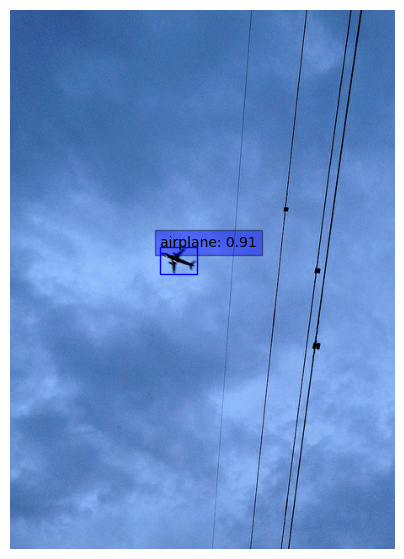

In [37]:
for sample in val_dataset.take(1):
    image = tf.cast(sample["image"], dtype=tf.float32)
    input_image, ratio = prepare_image(image)
    detections = inference_model.predict(input_image)
    num_detections = detections.valid_detections[0]
    class_names = [
        int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]
    ]
    visualize_detections(
        image,
        detections.nmsed_boxes[0][:num_detections] / ratio,
        class_names,
        detections.nmsed_scores[0][:num_detections],
    )